In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

In [2]:
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import scipy.stats as scs

In [3]:
%cd ..

/Users/yg/code/github/DS-GA-3001-001-Project


In [4]:
from torch.utils.data import DataLoader

from ts.benchmark.config import get_config
from ts.benchmark.trainer import Trainer
from ts.utils.data_loading import SeriesDataset
from ts.utils.helper_funcs import MODEL_TYPE, set_seed, create_datasets, generate_timeseries_length_stats, \
    filter_timeseries
from ts.utils.loss_modules import np_sMAPE

In [5]:
%pwd

'/Users/yg/code/github/DS-GA-3001-001-Project'

In [6]:
%load_ext autoreload
%autoreload 1

In [7]:
def load_data(ts_name):    
    set_seed(0)

    run_id = str(int(time.time()))
    print("Starting run={}, model={} ".format(run_id, MODEL_TYPE.BENCHMARK.value))

    BASE_DIR = Path("data/raw/")
    LOG_DIR = Path("logs/" + MODEL_TYPE.BENCHMARK.value)
    FIGURE_PATH = Path("figures-temp/" + MODEL_TYPE.BENCHMARK.value)

    print("Loading config")
    config = get_config(ts_name)
    print("Frequency:{}".format(config["variable"]))

    print("loading data")
    info = pd.read_csv(str(BASE_DIR / "M4Info.csv"))
    train_path = str(BASE_DIR / "train/%s-train.csv") % (config["variable"])
    test_path = str(BASE_DIR / "test/%s-test.csv") % (config["variable"])

    sample = config["sample"]
    sample_ids = config["sample_ids"] if "sample_ids" in config else []
    train, ts_labels, val, test, test_idx = create_datasets(train_path, test_path, config["output_size"],
                                                            create_val_dataset=True,
                                                            sample_ids=sample_ids, sample=sample,
                                                            sampling_size=4)
    generate_timeseries_length_stats(train)
    train_before_chopping_count = train.shape[0]
    print("#.Train before chopping:{}".format(train.shape[0]))
    chop_val = config["chop_val"]
    print("Chop value:{:6.3f}".format(chop_val))
    train, val, test, data_infocat_ohe, data_infocat_headers, data_info_cat = \
        filter_timeseries(info, config["variable"], sample, ts_labels, train, chop_val, val, test)
    train, val, test, data_infocat_ohe, data_infocat_headers, data_info_cat = \
        filter_timeseries(info, config["variable"], sample, ts_labels, train, chop_val, val, test)
    print("#.Train after chopping:{}, lost:{:5.2f}%".format(len(train),
                                                            (train_before_chopping_count - len(
                                                                train)) / train_before_chopping_count * 100.))
    print("#.train:{}, #.validation ts:{}, #.test ts:{}".format(len(train), len(val), len(test)))

    dataset = SeriesDataset(data_infocat_ohe, data_infocat_headers, data_info_cat, ts_labels,
                            train, val, test, config["device"])

    # dataloader = DataLoader(dataset, batch_size=config["batch_size"], collate_fn=collate_lines, shuffle=True)
    dataloader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=False)
    add_run_id = config["add_run_id"]
    return dataloader

# H344

In [8]:
dataloader = load_data("Hourly")

Starting run=1575637739, model=benchmark 
Loading config
Frequency:Hourly
loading data
train:1
Sampling train data for ['H344']
Sampling test data for ['H344']
        size
count    1.0
mean   912.0
std      NaN
min    912.0
25%    912.0
50%    912.0
75%    912.0
max    912.0
#.Train before chopping:1
Chop value:72.000
#.Train after chopping:1, lost: 0.00%
#.train:1, #.validation ts:1, #.test ts:1


In [9]:
(train, val, test, info_cat, ts_labels, idx) = next(iter(dataloader))
train_df = torch.cat((train, val), dim=1)
#val = pd.Series(val.squeeze().numpy())
test_df =  torch.cat((train_df, test), dim=1)
train_df = pd.Series(train_df.squeeze().numpy())
test_df = pd.Series(test_df.squeeze().numpy())

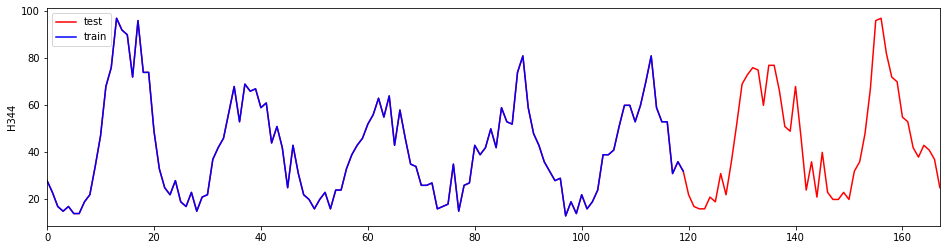

In [10]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
test_df.plot(ax=ax, label="test", color="r")
train_df.plot(ax=ax, label="train", color="b")
ax.set(ylabel="H344")
plt.legend();

In [11]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

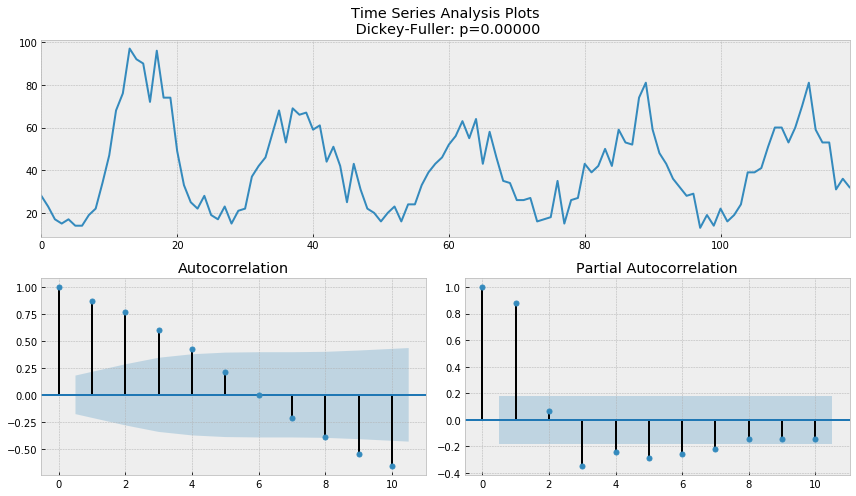

In [12]:
tsplot(train_df, lags=10)

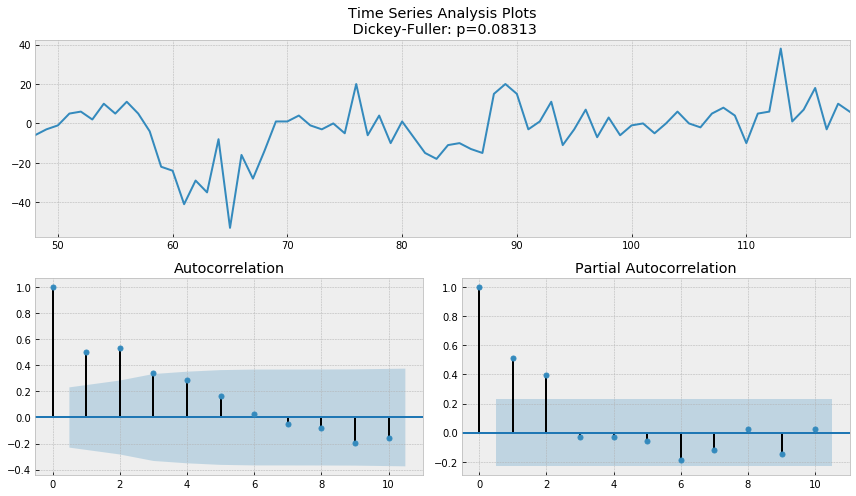

In [13]:
train_diff = train_df - train_df.shift(48)
tsplot(train_diff[48:], lags=10)

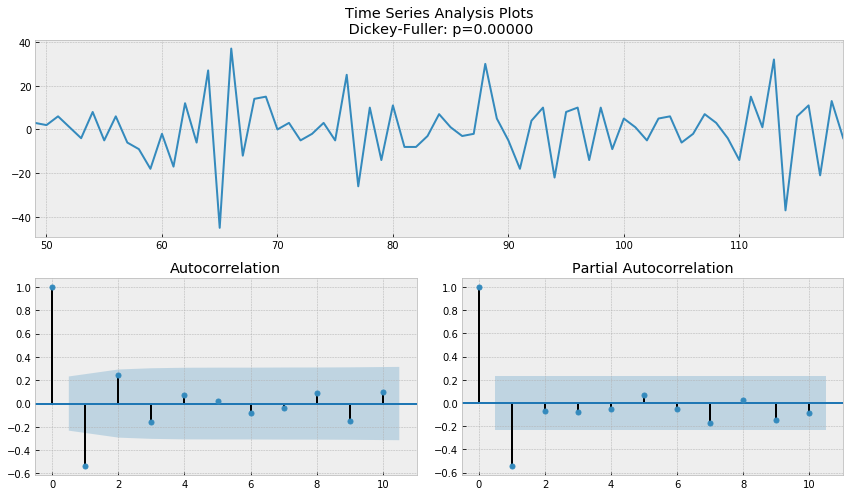

In [14]:
train_diff = train_diff - train_diff.shift(1)
tsplot(train_diff[48+1:], lags=10)

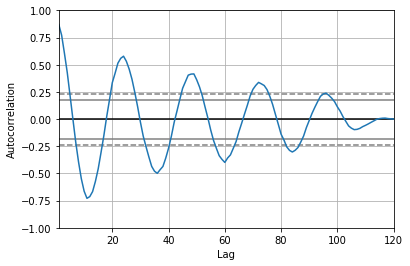

In [15]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train_df)

In [16]:
order = (6, 1, 5)
model = ARIMA(train_df, order)
fit = model.fit()

In [17]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  119
Model:                 ARIMA(6, 1, 5)   Log Likelihood                -418.452
Method:                       css-mle   S.D. of innovations              7.731
Date:                Fri, 06 Dec 2019   AIC                            862.904
Time:                        08:09:10   BIC                            899.032
Sample:                             1   HQIC                           877.575
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0561      0.161     -0.349      0.728      -0.371       0.259
ar.L1.D.y      0.0804      0.151      0.532      0.596      -0.216       0.377
ar.L2.D.y      0.5493      0.109      5.057      0.000       0.336       0.762
ar.L3.D.y      0.5359      0.130      4.129      0.000       0.282       0.790
ar.L4.D.y      0.4761      0.110      4.314      0.000       0.260       0.692
ar.L5.D.y     -0.7568      0.080     -9.425      0.000      -0.914      -0.599
ar.L6.D.y     -0.3443      0.105     -3.293      0.001      -0.549      -0.139
ma.L1.D.y     -0.5839      0.118     -4.937      0.000      -0.816      -0.352
ma.L2.D.y     -0.3255      0.163     -2.002      0.048      -0.644      -0.007
ma.L3.D.y     -0.5119      0.125     -4.097      0.000      -0.757      -0.267
ma.L4.D.y     -0.4035      0.163     -2.471      0.015      -0.724      -0.083
ma.L5.D.y      0.9278      0.110      8.473      0.000       0.713       1.142
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9726           -0.2642j            1.0078           -0.0422
AR.2            0.9726           +0.2642j            1.0078            0.0422
AR.3           -0.2625           -0.9944j            1.0284           -0.2911
AR.4           -0.2625           +0.9944j            1.0284            0.2911
AR.5           -1.0546           -0.0000j            1.0546           -0.5000
AR.6           -2.5638           -0.0000j            2.5638           -0.5000
MA.1           -1.0775           -0.0000j            1.0775           -0.5000
MA.2           -0.2331           -0.9725j            1.0000           -0.2874
MA.3           -0.2331           +0.9725j            1.0000            0.2874
MA.4            0.9893           -0.1468j            1.0001           -0.0235
MA.5            0.9893           +0.1468j            1.0001            0.0235
-----------------------------------------------------------------------------
"""

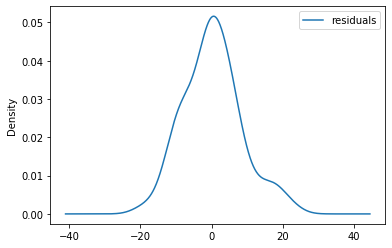

In [18]:
residuals = pd.DataFrame(fit.resid, columns=['residuals'])
residuals.plot(kind='kde')

In [19]:
train_df

0      28.0
1      23.0
2      17.0
3      15.0
4      17.0
       ... 
115    53.0
116    53.0
117    31.0
118    36.0
119    32.0
Length: 120, dtype: float32

In [20]:
preds = fit.predict(120, 167, typ='levels')

In [21]:
len(preds)

48

In [22]:
preds_df = pd.concat([train_df, preds])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


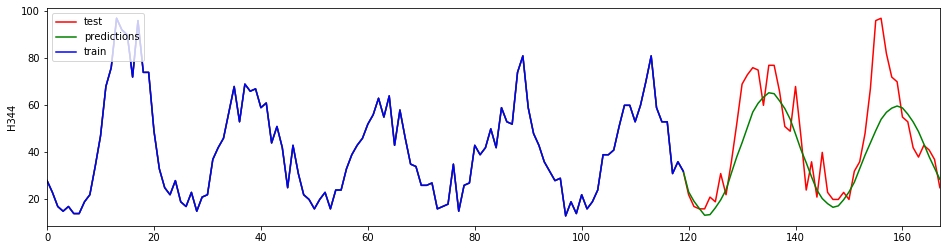

In [24]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
test_df.plot(ax=ax, label="test", color="r")
preds_df.plot(ax=ax, label="predictions", color="g")
train_df.plot(ax=ax, label="train", color="b")
ax.set(ylabel="H344")
plt.legend(loc="upper left");
plt.savefig("figures/benchmark/H344_ARIMA.eps", format="eps")

In [33]:
test_samples = pd.Series(test.squeeze().numpy())

In [34]:
print(len(test_samples))

48


In [35]:
np_sMAPE(preds, test_samples, 48)

21.579219818115234

# D1

In [68]:
dataloader = load_data("Daily")

Starting run=1575497449, model=benchmark 
Loading config
Frequency:Daily
loading data
train:1
Sampling train data for ['D1']
Sampling test data for ['D1']
        size
count    1.0
mean   992.0
std      NaN
min    992.0
25%    992.0
50%    992.0
75%    992.0
max    992.0
#.Train before chopping:1
Chop value:200.000
#.Train after chopping:1, lost: 0.00%
#.train:1, #.validation ts:1, #.test ts:1


In [69]:
def prepare_data(dataloader):
    (train, val, test, info_cat, ts_labels, idx) = next(iter(dataloader))
    train_df = torch.cat((train, val), dim=1)
    test_df =  torch.cat((train_df, test), dim=1)
    train_df = pd.Series(train_df.squeeze().numpy())
    test_df = pd.Series(test_df.squeeze().numpy())
    test_samples = pd.Series(test.squeeze().numpy())
    return train_df, test_df, test_samples

In [70]:
train_df, test_df, test_samples = prepare_data(dataloader)

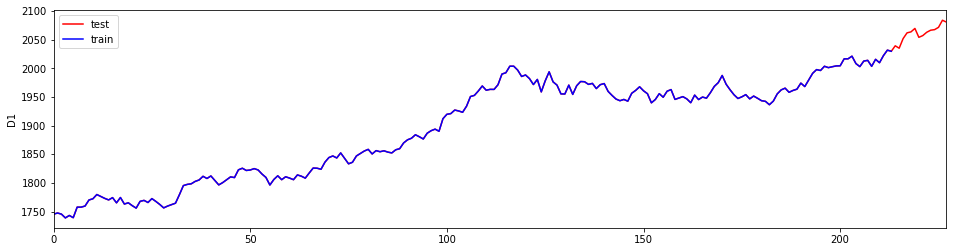

In [71]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
test_df.plot(ax=ax, label="test", color="r")
train_df.plot(ax=ax, label="train", color="b")
ax.set(ylabel="D1")
plt.legend();

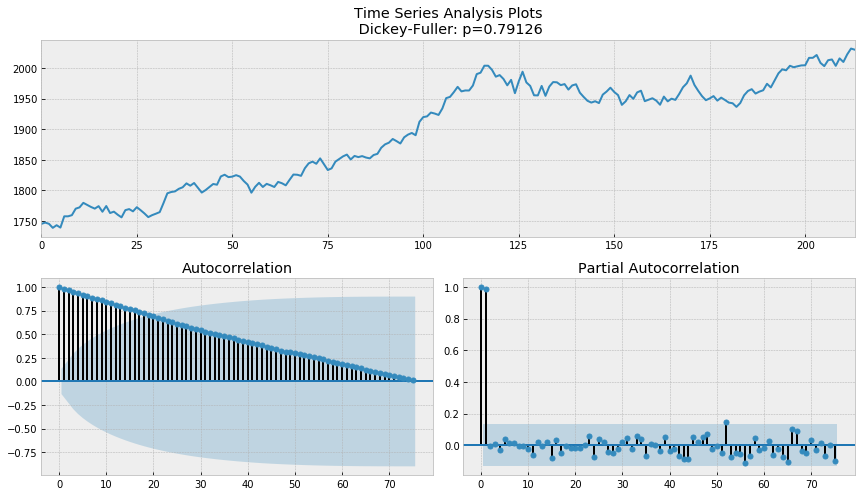

In [72]:
tsplot(train_df, lags=75)

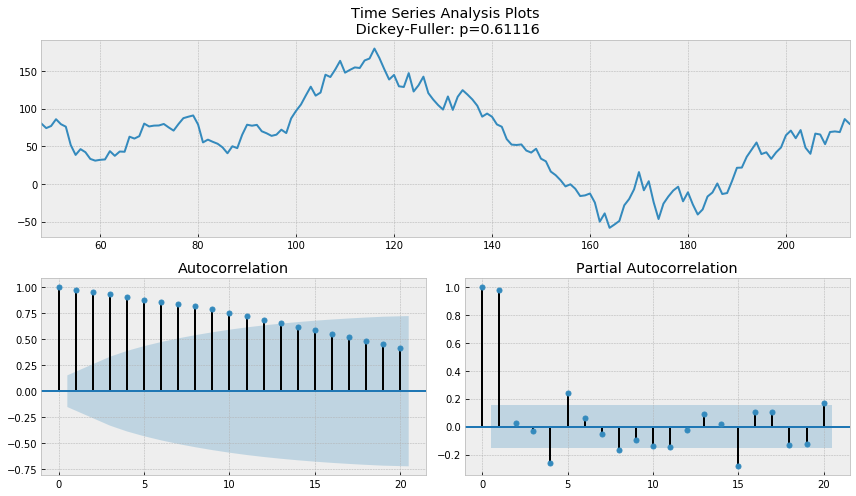

In [73]:
train_diff = train_df - train_df.shift(48)
tsplot(train_diff[48:], lags=20)

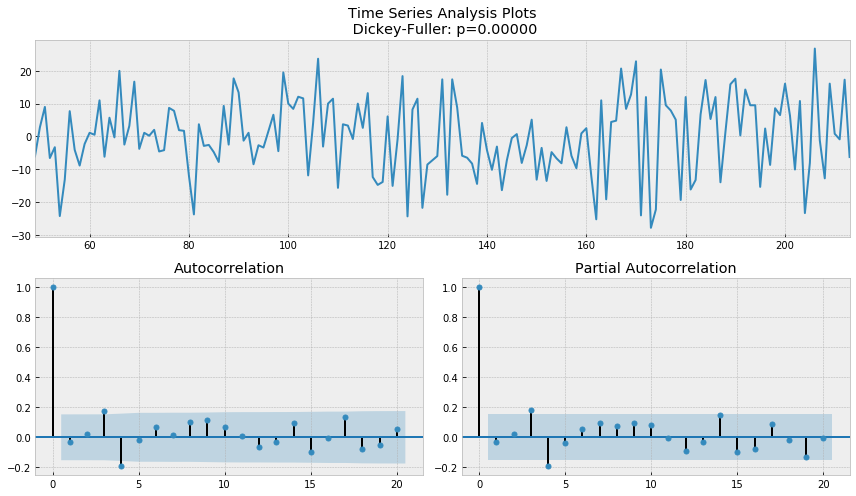

In [74]:
train_diff = train_diff - train_diff.shift(1)
tsplot(train_diff[48+1:], lags=20)

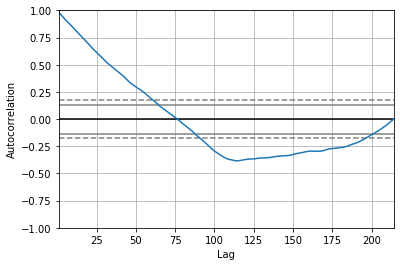

In [75]:
autocorrelation_plot(train_df)

In [76]:
order = (17, 1, 2)
model = ARIMA(train_df, order)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  213
Model:                ARIMA(17, 1, 2)   Log Likelihood                -731.543
Method:                       css-mle   S.D. of innovations              7.461
Date:                Wed, 04 Dec 2019   AIC                           1505.087
Time:                        17:11:30   BIC                           1575.674
Sample:                             1   HQIC                          1533.614
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3323      0.188      7.089      0.000       0.964       1.701
ar.L1.D.y      0.1689      0.312      0.540      0.590      -0.444       0.781
ar.L2.D.y      0.7939      0.293      2.707      0.007       0.219       1.369
ar.L3.D.y      0.0824      0.088      0.932      0.353      -0.091       0.256
ar.L4.D.y     -0.1864      0.089     -2.099      0.037      -0.360      -0.012
ar.L5.D.y     -0.0546      0.113     -0.482      0.630      -0.277       0.167
ar.L6.D.y      0.1320      0.095      1.383      0.168      -0.055       0.319
ar.L7.D.y      0.0256      0.087      0.293      0.770      -0.146       0.197
ar.L8.D.y      0.0634      0.089      0.714      0.476      -0.111       0.238
ar.L9.D.y      0.0732      0.091      0.809      0.420      -0.104       0.251
ar.L10.D.y    -0.0240      0.090     -0.267      0.790      -0.200       0.152
ar.L11.D.y    -0.0950      0.090     -1.054      0.293      -0.272       0.082
ar.L12.D.y    -0.0992      0.091     -1.096      0.274      -0.277       0.078
ar.L13.D.y     0.0469      0.092      0.509      0.611      -0.134       0.227
ar.L14.D.y     0.1841      0.092      2.006      0.046       0.004       0.364
ar.L15.D.y    -0.1024      0.098     -1.045      0.297      -0.294       0.090
ar.L16.D.y    -0.1561      0.080     -1.947      0.053      -0.313       0.001
ar.L17.D.y     0.0881      0.072      1.222      0.223      -0.053       0.229
ma.L1.D.y     -0.2156      0.308     -0.699      0.485      -0.820       0.389
ma.L2.D.y     -0.7844      0.308     -2.544      0.012      -1.389      -0.180
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0982           -0.1463j            1.1079           -0.4789
AR.2            -1.0982           +0.1463j            1.1079            0.4789
AR.3            -0.9856           -0.5219j            1.1152           -0.4225
AR.4            -0.9856           +0.5219j            1.1152            0.4225
AR.5            -0.6914           -0.8287j            1.0792           -0.3607
AR.6            -0.6914           +0.8287j            1.0792            0.3607
AR.7            -0.3132           -1.0638j            1.1090           -0.2956
AR.8            -0.3132           +1.0638j            1.1090            0.2956
AR.9             0.2100           -1.0892j            1.1092           -0.2197
AR.10            0.2100           +1.0892j            1.1092            0.2197
AR.11            0.7517           -0.8852j            1.1614           -0.1380
AR.12            0.7517           +0.8852j            1.1614            0.1380
AR.13            1.0111           -0.6555j            1.2050           -0.0915
AR.14            1.0111           +0.6555j            1.2050            0.0915
AR

In [77]:
train_df

0      1745.300049
1      1747.500000
2      1745.500000
3      1738.900024
4      1743.199951
          ...     
209    2015.599976
210    2009.699951
211    2022.099976
212    2031.599976
213    2029.699951
Length: 214, dtype: float32

In [78]:
len(test_samples)

14

In [80]:
preds = fit.predict(214, 227, typ="levels")
print(len(preds))
preds_df = pd.concat([train_df, preds])

14


In [81]:
len(preds_df)

228

In [67]:
len(test_df)

228

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


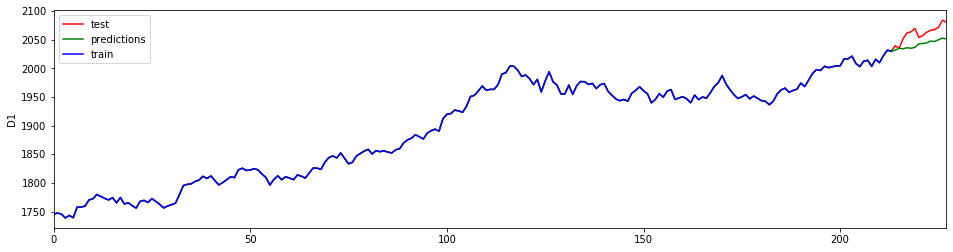

In [83]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
test_df.plot(ax=ax, label="test", color="r")
preds_df.plot(ax=ax, label="predictions", color="g")
train_df.plot(ax=ax, label="train", color="b")
ax.set(ylabel="D1")
plt.legend();
plt.savefig("figures/benchmark/D1_ARIMA.eps", format='eps')

In [84]:
np_sMAPE(preds, test_samples, 48)

0.28271254897117615

# W246

Starting run=1575497817, model=benchmark 
Loading config
Frequency:Weekly
loading data
train:1
Sampling train data for ['W246']
Sampling test data for ['W246']
         size
count     1.0
mean   1590.0
std       NaN
min    1590.0
25%    1590.0
50%    1590.0
75%    1590.0
max    1590.0
#.Train before chopping:1
Chop value:72.000
#.Train after chopping:1, lost: 0.00%
#.train:1, #.validation ts:1, #.test ts:1


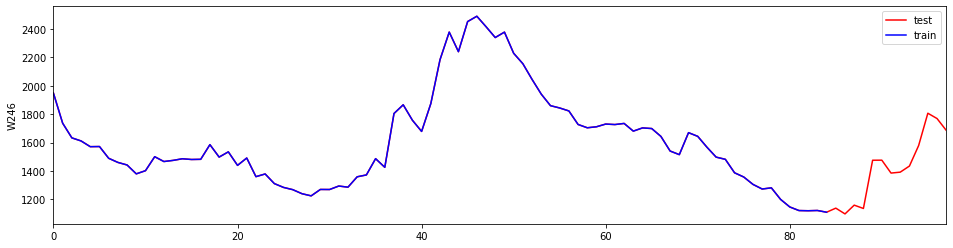

In [86]:
dataloader = load_data("Weekly")
train_df, test_df, test_samples = prepare_data(dataloader)
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
test_df.plot(ax=ax, label="test", color="r")
train_df.plot(ax=ax, label="train", color="b")
ax.set(ylabel="W246")
plt.legend();

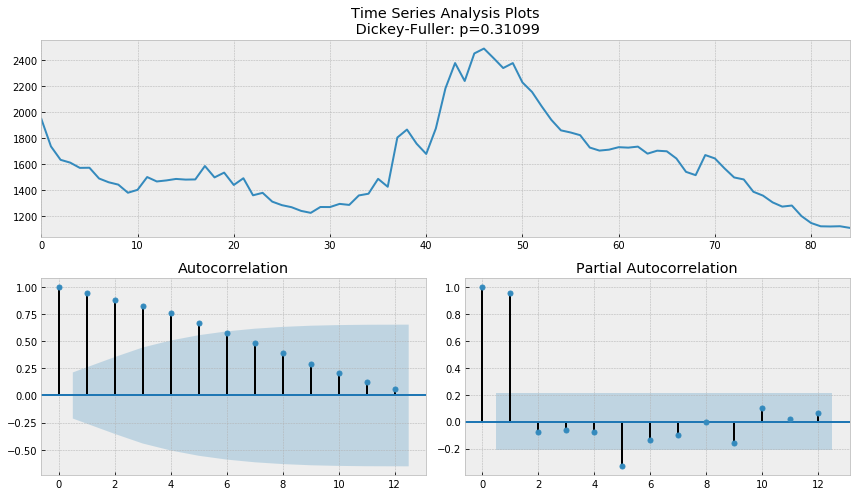

In [87]:
tsplot(train_df, lags=12)

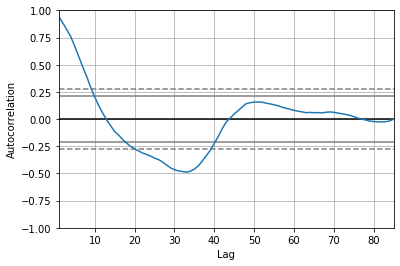

In [88]:
autocorrelation_plot(train_df)

In [89]:
order = (5, 0, 2)
model = ARIMA(train_df, order)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   85
Model:                     ARMA(5, 2)   Log Likelihood                -496.113
Method:                       css-mle   S.D. of innovations             80.958
Date:                Wed, 04 Dec 2019   AIC                           1010.226
Time:                        17:17:05   BIC                           1032.210
Sample:                             0   HQIC                          1019.069
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1642.1481    102.001     16.099      0.000    1442.230    1842.066
ar.L1.y        0.9662      0.188      5.147      0.000       0.598       1.334
ar.L2.y        0.4604      0.282      1.635      0.106      -0.092       1.012
ar.L3.y       -0.4898      0.223     -2.195      0.031      -0.927      -0.052
ar.L4.y        0.3642      0.157      2.320      0.023       0.057       0.672
ar.L5.y       -0.3554      0.116     -3.051      0.003      -0.584      -0.127
ma.L1.y        0.1473      0.196      0.751      0.455      -0.237       0.532
ma.L2.y       -0.5188      0.197     -2.636      0.010      -0.905      -0.133
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0579           -0.0000j            1.0579           -0.5000
AR.2            1.0309           -0.1438j            1.0409           -0.0221
AR.3            1.0309           +0.1438j            1.0409            0.0221
AR.4            0.0104           -1.5668j            1.5668           -0.2489
AR.5            0.0104           +1.5668j            1.5668            0.2489
MA.1           -1.2536           +0.0000j            1.2536            0.5000
MA.2            1.5375           +0.0000j            1.5375            0.0000
-----------------------------------------------------------------------------
"""

In [90]:
train_df

0     1948.699951
1     1737.099976
2     1633.699951
3     1612.099976
4     1571.699951
         ...     
80    1147.000000
81    1121.699951
82    1120.400024
83    1122.199951
84    1109.900024
Length: 85, dtype: float32

In [96]:
preds = fit.predict(84, 96)
preds_df = pd.concat([train_df, preds])

In [97]:
len(test_samples)

13

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


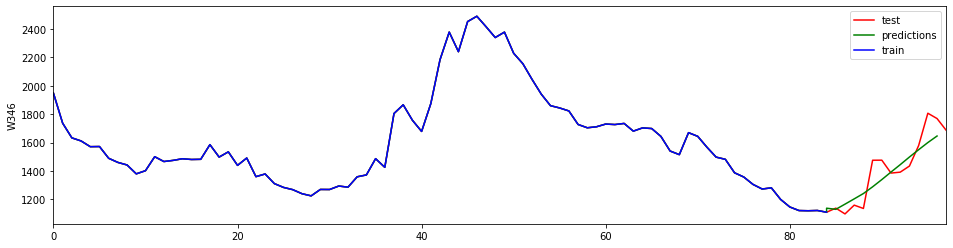

In [98]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
test_df.plot(ax=ax, label="test", color="r")
preds_df.plot(ax=ax, label="predictions", color="g")
train_df.plot(ax=ax, label="train", color="b")
ax.set(ylabel="W346")
plt.legend();
plt.savefig("figures/benchmark/W346_ARIMA.eps", format='eps')

In [99]:
np_sMAPE(preds, test_samples, 14)

5.517005443572998

# M1 

Starting run=1575497939, model=benchmark 
Loading config
Frequency:Monthly
loading data
train:1
Sampling train data for ['M1']
Sampling test data for ['M1']
        size
count    1.0
mean   451.0
std      NaN
min    451.0
25%    451.0
50%    451.0
75%    451.0
max    451.0
#.Train before chopping:1
Chop value:72.000
#.Train after chopping:1, lost: 0.00%
#.train:1, #.validation ts:1, #.test ts:1


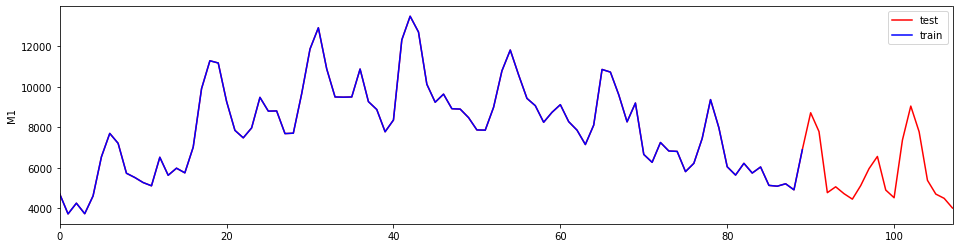

In [100]:
dataloader = load_data("Monthly")
train_df, test_df, test_samples = prepare_data(dataloader)
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
test_df.plot(ax=ax, label="test", color="r")
train_df.plot(ax=ax, label="train", color="b")
ax.set(ylabel="M1")
plt.legend();

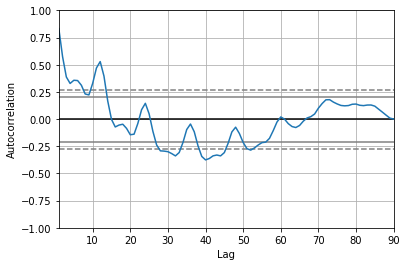

In [101]:
autocorrelation_plot(train_df)

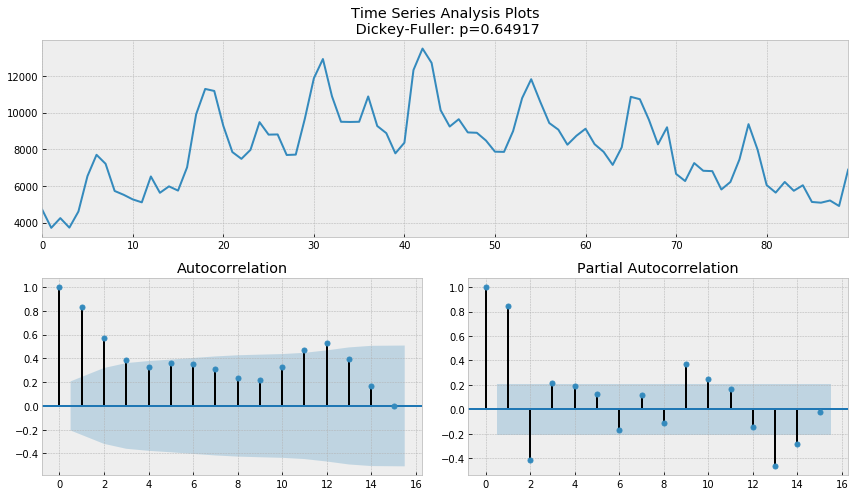

In [102]:
tsplot(train_df, lags=15)

In [106]:
order = (3, 0, 2)
model = ARIMA(train_df, order)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   90
Model:                     ARMA(3, 2)   Log Likelihood                -746.519
Method:                       css-mle   S.D. of innovations            924.097
Date:                Wed, 04 Dec 2019   AIC                           1507.037
Time:                        17:20:42   BIC                           1524.536
Sample:                             0   HQIC                          1514.094
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8313.8394   1035.503      8.029      0.000    6284.291    1.03e+04
ar.L1.y        1.9128        nan        nan        nan         nan         nan
ar.L2.y       -1.9129        nan        nan        nan         nan         nan
ar.L3.y        0.9155      0.008    110.831      0.000       0.899       0.932
ma.L1.y       -1.0084      0.057    -17.699      0.000      -1.120      -0.897
ma.L2.y        0.9987      0.090     11.061      0.000       0.822       1.176
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4987           -0.8669j            1.0001           -0.1669
AR.2            0.4987           +0.8669j            1.0001            0.1669
AR.3            1.0922           -0.0000j            1.0922           -0.0000
MA.1            0.5049           -0.8639j            1.0006           -0.1658
MA.2            0.5049           +0.8639j            1.0006            0.1658
-----------------------------------------------------------------------------
"""

In [108]:
train_df

0     4710.0
1     3720.0
2     4250.0
3     3730.0
4     4610.0
       ...  
85    5130.0
86    5090.0
87    5210.0
88    4910.0
89    6890.0
Length: 90, dtype: float32

In [109]:
len(test_samples)

18

In [112]:
preds = fit.predict(89, 106)
preds_df = pd.concat([train_df, preds])

In [113]:
len(preds)

18

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


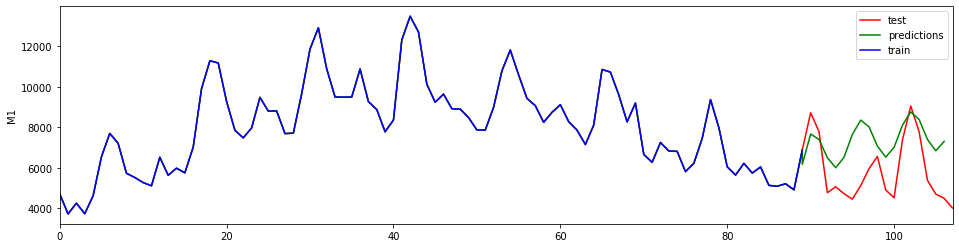

In [114]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
test_df.plot(ax=ax, label="test", color="r")
preds_df.plot(ax=ax, label="predictions", color="g")
train_df.plot(ax=ax, label="train", color="b")
ax.set(ylabel="M1")
plt.legend();
plt.savefig("figures/benchmark/M1_ARIMA.eps", format="eps")

In [115]:
np_sMAPE(preds, test_samples, 18)

30.403629302978516

# Q66

Starting run=1575498205, model=benchmark 
Loading config
Frequency:Quarterly
loading data
train:1
Sampling train data for ['Q66']
Sampling test data for ['Q66']
        size
count    1.0
mean   211.0
std      NaN
min    211.0
25%    211.0
50%    211.0
75%    211.0
max    211.0
#.Train before chopping:1
Chop value:72.000
#.Train after chopping:1, lost: 0.00%
#.train:1, #.validation ts:1, #.test ts:1


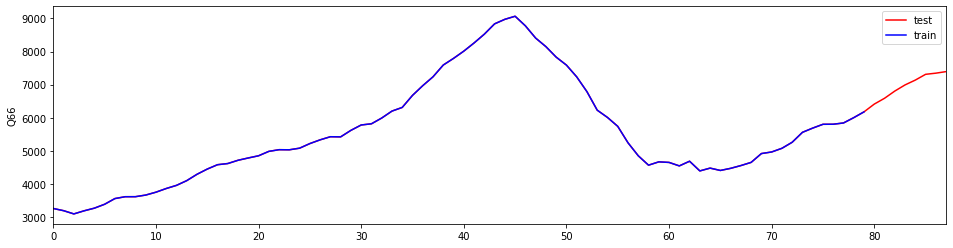

In [116]:
dataloader = load_data("Quarterly")
train_df, test_df, test_samples = prepare_data(dataloader)
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
test_df.plot(ax=ax, label="test", color="r")
train_df.plot(ax=ax, label="train", color="b")
ax.set(ylabel="Q66")
plt.legend();

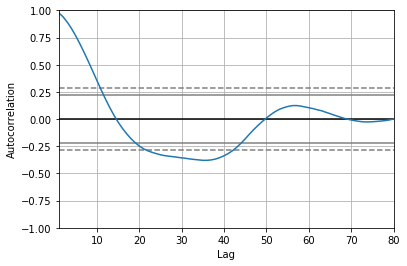

In [117]:
autocorrelation_plot(train_df)

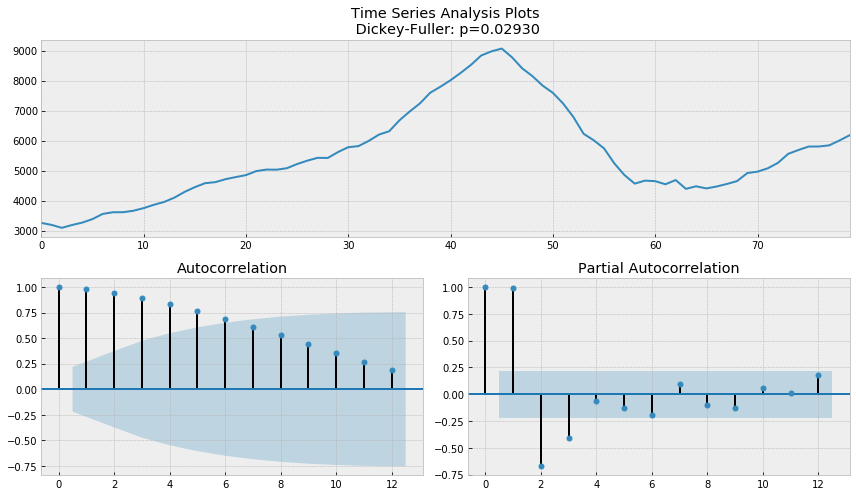

In [118]:
tsplot(train_df, lags=12)

In [123]:
order = (4, 0, 2)
model = ARIMA(train_df, order)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   80
Model:                     ARMA(4, 2)   Log Likelihood                -498.191
Method:                       css-mle   S.D. of innovations            117.529
Date:                Wed, 04 Dec 2019   AIC                           1012.383
Time:                        17:25:11   BIC                           1031.439
Sample:                             0   HQIC                          1020.023
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5560.9480    624.172      8.909      0.000    4337.594    6784.302
ar.L1.y        0.4111      0.463      0.888      0.377      -0.496       1.318
ar.L2.y        1.1820      0.297      3.979      0.000       0.600       1.764
ar.L3.y       -0.0724      0.591     -0.122      0.903      -1.232       1.087
ar.L4.y       -0.5692      0.400     -1.424      0.159      -1.353       0.214
ma.L1.y        1.1688      0.578      2.024      0.047       0.037       2.301
ma.L2.y        0.3014      0.688      0.438      0.663      -1.048       1.650
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0594           -0.1196j            1.0661           -0.0179
AR.2            1.0594           +0.1196j            1.0661            0.0179
AR.3           -1.1230           -0.5334j            1.2432           -0.4294
AR.4           -1.1230           +0.5334j            1.2432            0.4294
MA.1           -1.2743           +0.0000j            1.2743            0.5000
MA.2           -2.6038           +0.0000j            2.6038            0.5000
-----------------------------------------------------------------------------
"""

In [124]:
train_df

0     3255.0
1     3189.0
2     3091.0
3     3185.0
4     3265.0
       ...  
75    5801.0
76    5803.0
77    5841.0
78    6002.0
79    6177.0
Length: 80, dtype: float32

In [125]:
len(test_samples)

8

In [127]:
preds = fit.predict(80, 87)
preds_df = pd.concat([train_df, preds])
print(len(preds))

8


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


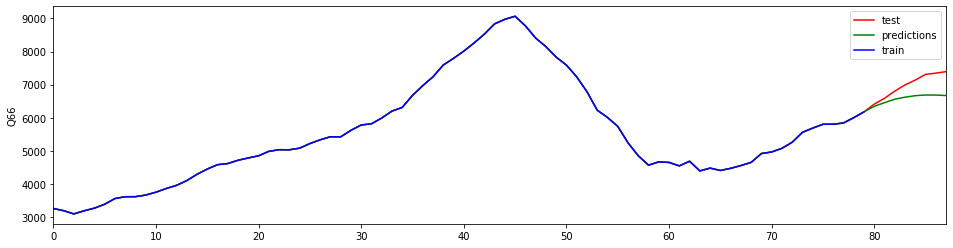

In [128]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
test_df.plot(ax=ax, label="test", color="r")
preds_df.plot(ax=ax, label="predictions", color="g")
train_df.plot(ax=ax, label="train", color="b")
ax.set(ylabel="Q66")
plt.legend();
plt.savefig("figures/benchmark/Q66_ARIMA.eps", format="eps")

In [129]:
np_sMAPE(preds, test_samples, 8)

5.966838836669922

# Y1

Starting run=1575498500, model=benchmark 
Loading config
Frequency:Yearly
loading data
train:1
Sampling train data for ['Y1']
Sampling test data for ['Y1']
       size
count   1.0
mean   25.0
std     NaN
min    25.0
25%    25.0
50%    25.0
75%    25.0
max    25.0
#.Train before chopping:1
Chop value:25.000
#.Train after chopping:1, lost: 0.00%
#.train:1, #.validation ts:1, #.test ts:1


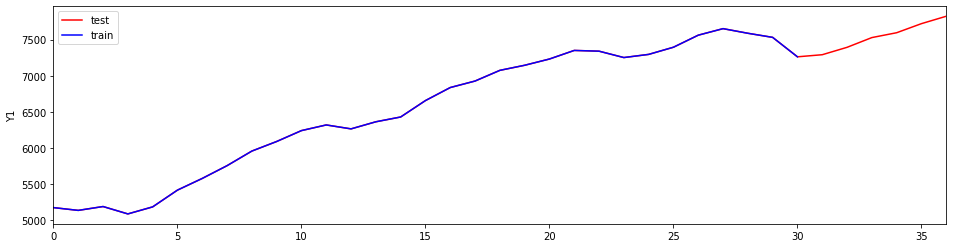

In [131]:
dataloader = load_data("Yearly")
train_df, test_df, test_samples = prepare_data(dataloader)
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
test_df.plot(ax=ax, label="test", color="r")
train_df.plot(ax=ax, label="train", color="b")
ax.set(ylabel="Y1")
plt.legend();

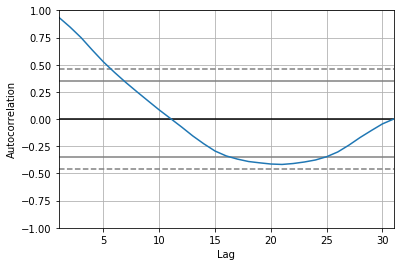

In [132]:
autocorrelation_plot(train_df)

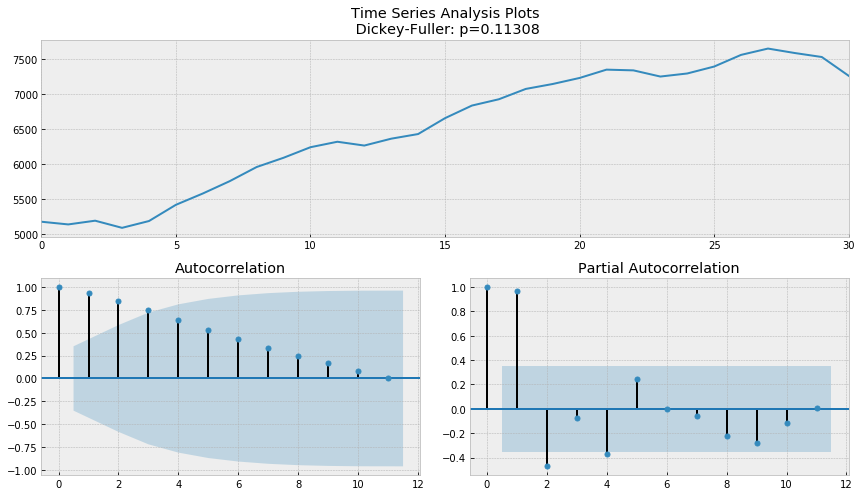

In [134]:
tsplot(train_df, lags=11)

In [139]:
order = (2, 0, 1)
model = ARIMA(train_df, order)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:                     ARMA(2, 1)   Log Likelihood                -187.372
Method:                       css-mle   S.D. of innovations             93.680
Date:                Wed, 04 Dec 2019   AIC                            384.745
Time:                        17:29:45   BIC                            391.915
Sample:                             0   HQIC                           387.082
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6299.5673    457.824     13.760      0.000    5402.248    7196.886
ar.L1.y        1.8275      0.142     12.864      0.000       1.549       2.106
ar.L2.y       -0.8532      0.145     -5.870      0.000      -1.138      -0.568
ma.L1.y       -0.2325      0.281     -0.828      0.415      -0.783       0.318
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0710           -0.1585j            1.0826           -0.0234
AR.2            1.0710           +0.1585j            1.0826            0.0234
MA.1            4.3008           +0.0000j            4.3008            0.0000
-----------------------------------------------------------------------------
"""

In [140]:
train_df

0     5172.100098
1     5133.500000
2     5186.899902
3     5084.600098
4     5182.000000
5     5414.299805
6     5576.200195
7     5752.899902
8     5955.200195
9     6087.799805
10    6238.899902
11    6317.200195
12    6262.700195
13    6361.000000
14    6427.399902
15    6654.899902
16    6835.399902
17    6925.500000
18    7073.500000
19    7144.000000
20    7230.600098
21    7349.600098
22    7339.200195
23    7250.799805
24    7294.600098
25    7393.899902
26    7560.899902
27    7651.399902
28    7587.299805
29    7530.500000
30    7261.100098
dtype: float32

In [141]:
len(test_samples)

6

In [142]:
preds = fit.predict(30, 35)
preds_df = pd.concat([train_df, preds])
print(len(preds))

6


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


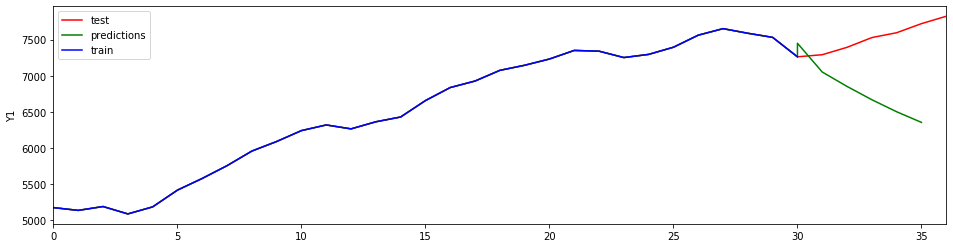

In [144]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
test_df.plot(ax=ax, label="test", color="r")
preds_df.plot(ax=ax, label="predictions", color="g")
train_df.plot(ax=ax, label="train", color="b")
ax.set(ylabel="Y1")
plt.legend();
plt.savefig("figures/benchmark/Y1_ARIMA.eps", format="eps")

In [145]:
np_sMAPE(preds, test_samples, 6)

11.20602798461914